## Laboratory work 2
NN architecture: AlexNet <br>
Dataset: Cifar10 <br>
link to dataset: https://www.cs.toronto.edu/~kriz/cifar.html

## The CIFAR-10 dataset
The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class.

### Imports

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.optim as optim
import torch.nn as nn
import torchmetrics
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, train_test_split
import gc

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Setting random number seed

In [3]:
# Seed the RNG for all devices (both CPU and CUDA)
torch.manual_seed(0)
# Set python seed
random.seed(0)
# Set numpy seed
np.random.seed(0)
# Force cuDNN to deterministically select an algorithm
# *possibly at the cost of reduced performance
torch.backends.cudnn.benchmark = False
# Configure PyTorch to use deterministic algorithms
# torch.use_deterministic_algorithms(True) (involves env. variables, so not used)
rand_const = 0

In [4]:
# Worker initialization function for data loaders (simplest approach)
def seed_worker(worker_id):
    worker_seed = (torch.initial_seed() + worker_id) % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g_train = torch.Generator().manual_seed(0)
g_test = torch.Generator().manual_seed(1)

### Data read

This dataset already has train and test split (0.833 - 50000 to 0.167 - 10000). Let's further split it into:
```
1. train set           66.6%       40000 images
2. validation set      16.7%       10000 images
3. test set            16.7%       10000 images
Total images used for sets: 60000
```

In [5]:
train_set_img_cnt = 40000
valid_set_img_cnt = 10000
test_set_img_cnt = 10000

### Define transformers for data

In [6]:
# Calculate mean and std of test and train sets (255 - possible pixel value range)
traindata = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True).data / 255
testdata = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True).data / 255
mean_trn = traindata.mean(axis = (0,1,2)) 
std_trn = traindata.std(axis = (0,1,2))
mean_tst = testdata.mean(axis = (0,1,2)) 
std_tst = testdata.std(axis = (0,1,2))


# Create sequence of transformations: data -> resize to 227 x 227 -> 
#            -> (random horizontal flip for training data) -> tensor -> (tensor - mean) / std
transform_train = transforms.Compose([
    transforms.Resize(227),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean_trn, std_trn),
])

transform_test = transforms.Compose([
    transforms.Resize(227),
    transforms.ToTensor(),
    transforms.Normalize(mean_tst, std_tst),
])

# Number of images in each batch, recommended to == 2^n
batch_size = 32

# 10 classes used in CIFAR10 dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Clear memory
del traindata
del testdata
gc.collect()

100%|██████████| 170498071/170498071 [00:05<00:00, 28664632.10it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


30

### Creating dataloaders for train, validation and test datasets

In [7]:
# Download CIFAR10 trainset
trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=False, transform=transform_train)

labels = trainset.targets

# Perform stratified random split into training (70%) and validation (30%) sets
train_indexes, val_indexes = train_test_split(list(range(len(trainset))), test_size=0.2, random_state=rand_const, stratify=labels)

# Create train and validation datasets
train_dataset = torch.utils.data.Subset(trainset, train_indexes)
val_dataset = torch.utils.data.Subset(trainset, val_indexes)

# Create a sampler, that provides an iterable over the train and validation sets
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, worker_init_fn=seed_worker, generator=g_train)
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=True, num_workers=0, worker_init_fn=seed_worker, generator=g_train)

In [8]:
# Download CIFAR10 testset
testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=False, transform=transform_test)

# Create a sampler for testset
test_loader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size, shuffle=False, num_workers=0, worker_init_fn=seed_worker, generator=g_test)

### Data visualization

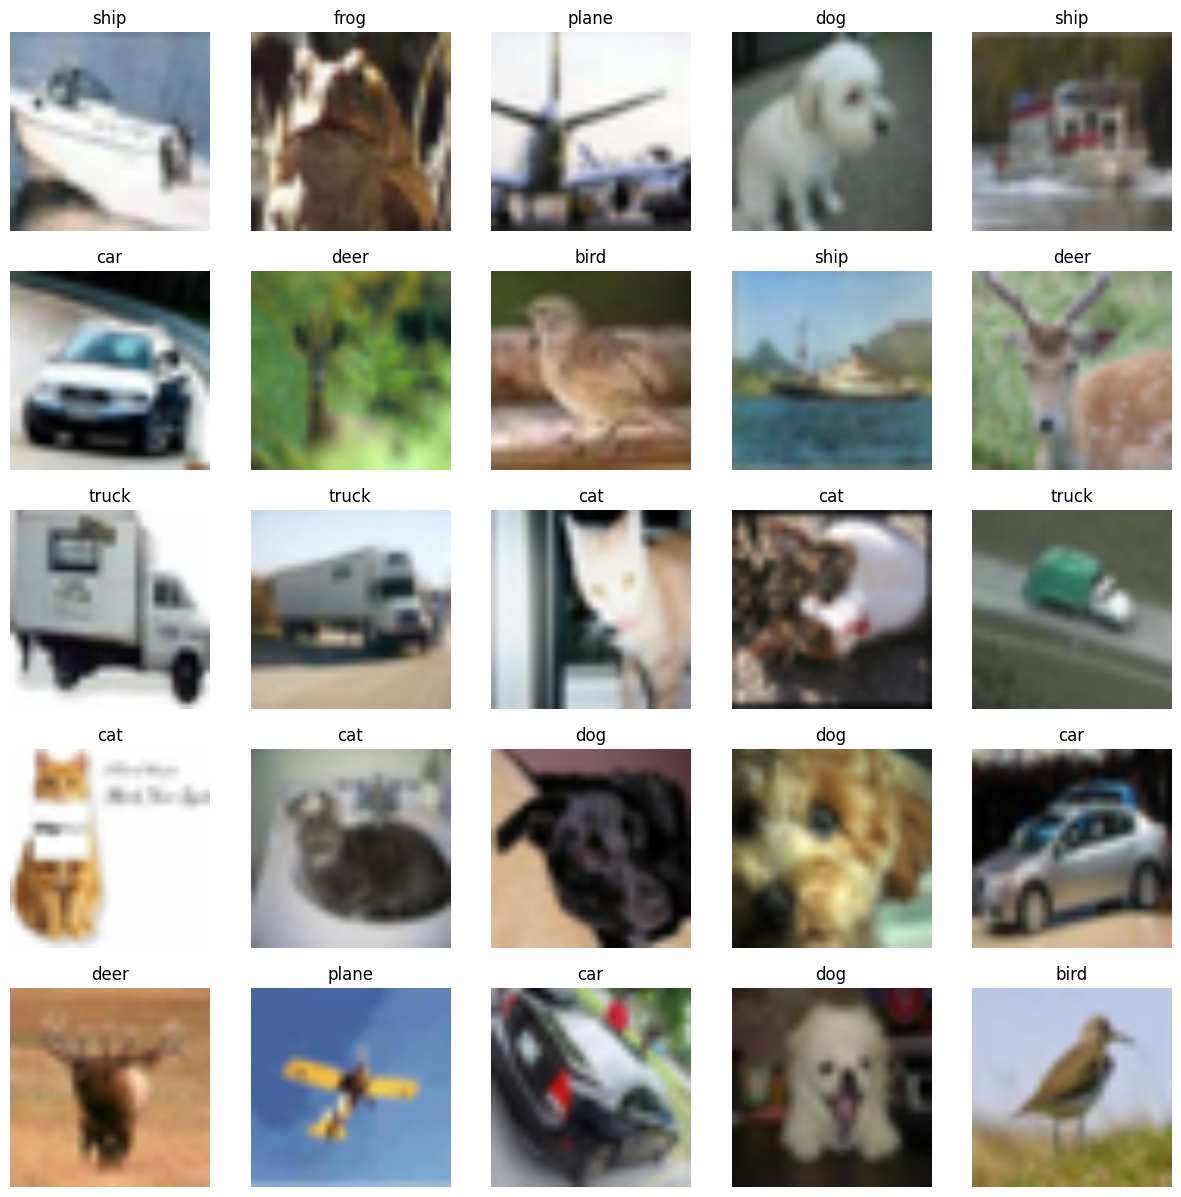

In [9]:
def imshow(img):
    # Unnormalize image
    img = img * std_trn[:, None, None] + mean_trn[:, None, None]
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# Get some training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images and labels in a grid 5x5
fig = plt.figure(figsize=(15, 15))
rows, cols = 5, 5
for i in range(0, rows * cols):
    img, label = images[i], labels[i]
    fig.add_subplot(rows, cols, i + 1)
    imshow(img)
    plt.title(classes[label])
    plt.axis(False)

In [10]:
train_batches_num = len(train_loader)
val_batches_num = len(val_loader)
test_batches_num = len(test_loader)
print(f"Amount of batches processed in each epoch during full training: {train_batches_num}")

Amount of batches processed in each epoch during full training: 1250


### Architecture of custom AlexNet

In [11]:
class CustomAlexNet(nn.Module):
    def __init__(self, num_classes: int = 10, dropout: float = 0.5) -> None:
        super().__init__()
        # Define convolutional part
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256,out_channels= 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        # Define fully connected classification part
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
            nn.Softmax(dim=1),
        )

    # Define forward function
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv_layers(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [12]:
# Set up loss criterion
criterion = nn.CrossEntropyLoss()
# Set up and send to GPU accuracy metric
accuracy = torchmetrics.Accuracy(task = 'multiclass', num_classes=len(classes)).to(device)

### We won't use cross-validation and grid-search for hyperparameter tuning due to the fact that training the network requires many epochs even without these techniques. Let's first try training model until the point of overfitting. In this notebook we start from epoch 100 pretrained model, because due to many epochs required model was trained several times starting from previous progress.

In [14]:
# Set up stohastic gradient descent method of NN training with
# learning rate = 0.001
# momentum = 0.9
# dropout = 0.5
# (original values from scientific paper)
custom_alexnet_pretr = CustomAlexNet().to(device)
optimizer = optim.SGD(custom_alexnet_pretr.parameters(), lr=0.001, momentum=0.9)

# Download CustomAlexNet previously trained for 100 epochs
custom_alexnet_pretr.load_state_dict(torch.load('/kaggle/input/data-for-train/CustomAlexNet_100epoch.pth'))
# Arrays that store loss and accuracy calculated during 100 epoch training
train_loss_arr_pretr = np.load('/kaggle/input/data-for-train/train_loss_arr_100_conc.npy')
val_loss_arr_pretr = np.load('/kaggle/input/data-for-train/val_loss_arr_100_conc.npy')
val_accuracy_arr_pretr = np.load('/kaggle/input/data-for-train/val_accuracy_arr_100_conc.npy')

### Class, that creates abstraction for model, dataloaders, optimizer, criterion, etc., and allows to train, validate and test this model

In [39]:
class ModelCycles:
    def __init__(self, model, optimizer, criterion, accuracy, train_loader, val_loader, test_loader, device):
        """
        Parameters
        ----------
        train_loader :
            Batch loader of train data
        val_loader :
            Batch loader of validation data
        test_loader :
            Batch loader of test data
        device :
            Device where data will be sent to (for example cuda)
        """

        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.accuracy = accuracy
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.device = device
        self.train_batches_num = len(train_loader)
        self.val_batches_num = len(val_loader)
        self.test_batches_num = len(test_loader)
        
    def train_validate_cycle(self, epochs, cycle_batch, cycle_epoch):
        """
        Parameters
        ----------
        epochs :
            Number of training and validation cycle epochs
        cycle_batch : 
            The number that determines after which amount of batches in each epoch information will be displayed
        cycle_epoch :
            The number that determines after which amount of epochs information will be displayed
        """
        # Define flag for info display
        print_ind = False

        # Create required arrays to store loss and accuracy
        self.train_loss_arr = np.zeros(epochs)
        self.val_loss_arr = np.zeros(epochs)
        self.val_accuracy_arr = np.zeros(epochs)

        # Create training and validation loop
        for epoch in range(epochs):
            if (epoch + 1) % cycle_epoch == 0:
                print(f"Current epoch: {epoch + 1}\n-------")
                print_ind = True

            ##### Training #####
            train_loss = val_acc = val_loss = 0
            # Set network to train mode
            self.model.train()

            # Add a loop through training batches
            for batch_num, (tr_inputs, tr_labels) in enumerate(self.train_loader):
                # Send data to cuda (preferably)
                tr_inputs = tr_inputs.to(device)
                tr_labels = tr_labels.to(device)

                # Zero the parameter gradients
                self.optimizer.zero_grad()

                # Forward, backward pass + optimization
                outputs = self.model(tr_inputs).to(device)
                loss = self.criterion(outputs, tr_labels)
                loss.backward()
                self.optimizer.step()

                # Accumulatively add up the loss per epoch 
                train_loss += loss

                # Print out how many samples have been seen
                # Save loss each cycle batches (cycle*batch samples)
                if (batch_num + 1) % cycle_batch == 0 and batch_num != 0 and print_ind:
                    print(f"Looked at {batch_num * batch_size} samples")
                    print(f"Current train loss for batch: {loss}")

                # Clearing memory
                del tr_inputs
                del tr_labels
                del outputs
            ##### Training end #####

            ##### Validation #####
            # Set network to evaluation mode
            self.model.eval()
            # Turn on inference mode (no autograd)
            with torch.inference_mode():
                for val_inputs, val_labels in self.val_loader:
                    # Send data to cuda (preferably)
                    val_inputs = val_inputs.to(device)
                    val_labels = val_labels.to(device)
                    predictions = self.model(val_inputs).to(device)

                    # Test loss and accuracy calculation
                    val_loss += self.criterion(predictions, val_labels)
                    val_acc += self.accuracy(predictions.argmax(dim=1), val_labels)

                    # Clearing memory
                    del val_inputs
                    del val_labels
                    del predictions
            ##### Validation end #####

                # Save average (throughout the epoch) loss and accuracy
                self.train_loss_arr[epoch] = train_loss / self.train_batches_num
                self.val_loss_arr[epoch] = val_loss / self.val_batches_num
                self.val_accuracy_arr[epoch] = val_acc / self.val_batches_num

                if (epoch + 1) % cycle_epoch == 0:
                    # Print out average loss and accuracy of this epoch
                    print(f"\nAverage train loss: {self.train_loss_arr[epoch]:.5f}")
                    print(f"Average validation loss: {self.val_loss_arr[epoch]:.5f}, Average validation acc: {self.val_accuracy_arr[epoch]:.2f}%\n")
                    print_ind = False

            gc.collect()
            torch.cuda.empty_cache()
            
    
    def model_test(self):
        test_loss = test_acc = 0
        
        ##### Test #####
        # Set network to evaluation mode
        self.model.eval()
        # Turn on inference mode (no autograd)
        with torch.inference_mode():
            for test_inputs, test_labels in self.test_loader:
                # Send data to cuda (preferably)
                test_inputs = test_inputs.to(device)
                test_labels = test_labels.to(device)
                predictions = self.model(test_inputs).to(device)

                # Test loss and accuracy calculation
                test_loss += self.criterion(predictions, test_labels)
                test_acc += self.accuracy(predictions.argmax(dim=1), test_labels)

                # Clearing memory
                del test_inputs
                del test_labels
                del predictions
        ##### Test end #####

            # Save average (throughout the epoch) loss and accuracy
            test_loss_score = test_loss / self.test_batches_num
            test_accuracy_score = test_acc / self.test_batches_num

            gc.collect()
            torch.cuda.empty_cache()

        return test_loss_score, test_accuracy_score
    
    @staticmethod
    def plot_loss_acc(epochs, train_loss_arr, val_loss_arr, val_accuracy_arr):
        plt.figure(figsize = (15, 5))
        epoch_arr = np.arange(1, epochs + 1)
        plt.subplot(121)
        plt.plot(epoch_arr, train_loss_arr, 'r', label='Average train loss')
        plt.plot(epoch_arr, val_loss_arr,'b', label='Average validation loss')
        plt.title("Average loss")
        plt.legend()
        plt.xlabel("Epoch number")
        plt.ylabel("Loss value")
        plt.subplot(122)
        plt.plot(epoch_arr, val_accuracy_arr, 'b')
        plt.title("Average validation accuracy")
        plt.xlabel("Epoch number")
        plt.ylabel("Validation accuracy value")
        plt.show()

In [22]:
# Create model for pretrained (100 epochs) CustomAlexNet that
# allows to go through train-validation loops and perform test
CAN_pretr_model_cycle = ModelCycles(custom_alexnet_pretr, optimizer, criterion, accuracy, 
                                    train_loader, val_loader, test_loader, device)

In [23]:
CAN_pretr_model_cycle.train_validate_cycle(40, 400, 2)

Current epoch: 2
-------
Looked at 12768 samples
Current train loss for batch: 1.6486194133758545
Looked at 25568 samples
Current train loss for batch: 1.6784541606903076
Looked at 38368 samples
Current train loss for batch: 1.5884394645690918

Average train loss: 1.64758
Average validation loss: 1.71842, Average validation acc: 0.74%

Current epoch: 4
-------
Looked at 12768 samples
Current train loss for batch: 1.524250864982605
Looked at 25568 samples
Current train loss for batch: 1.5546107292175293
Looked at 38368 samples
Current train loss for batch: 1.646889328956604

Average train loss: 1.64327
Average validation loss: 1.71304, Average validation acc: 0.75%

Current epoch: 6
-------
Looked at 12768 samples
Current train loss for batch: 1.6394096612930298
Looked at 25568 samples
Current train loss for batch: 1.7132468223571777
Looked at 38368 samples
Current train loss for batch: 1.5856705904006958

Average train loss: 1.64109
Average validation loss: 1.70672, Average validation 

### Accuracy and loss plots

In [31]:
train_loss_arr_pretr.shape

(100,)

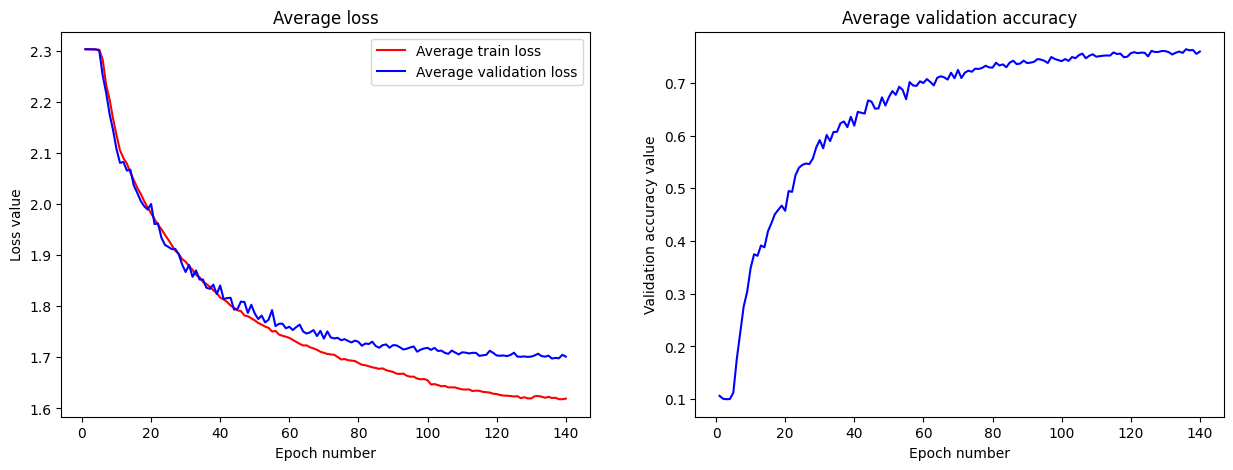

In [32]:
train_loss_arr_140 = np.concatenate((train_loss_arr_pretr, CAN_pretr_model_cycle.train_loss_arr))
val_loss_arr_140 = np.concatenate((val_loss_arr_pretr, CAN_pretr_model_cycle.val_loss_arr))
val_accuracy_arr_140 = np.concatenate((val_accuracy_arr_pretr, CAN_pretr_model_cycle.val_accuracy_arr))
ModelCycles.plot_loss_acc(140, train_loss_arr_140, val_loss_arr_140, val_accuracy_arr_140)

### As we see, somewhere just starting from epoch 140, the model begins to overfit (to confirm this we need to continue training), because validation loss stops to fall (and will start to rise) and validation accuracy stops to rise. Let's check results of our models on test set:

In [33]:
# Save weights to file 'AlexNet_nonPL_CIFAR10_weights.pth'
torch.save(custom_alexnet_pretr.state_dict(), 'CustomAlexNet_140epoch.pth')
# To load weigths:
# custom_alexnet_pretr.load_state_dict(torch.load('CustomAlexNet_140epoch.pth''))
# custom_alexnet_pretr.eval()
np.save('train_loss_arr_140.npy', train_loss_arr_140)
np.save('val_loss_arr_140.npy', val_loss_arr_140)
np.save('val_accuracy_arr_140.npy', val_accuracy_arr_140)

In [41]:
test_loss_score, test_accuracy_score = CAN_pretr_model_cycle.model_test()
print(f"Test loss: {test_loss_score}")
print(f"Test accuracy: {test_accuracy_score}")

Test loss: 1.7000794410705566
Test accuracy: 0.7611820697784424


### We get pretty decent result of accuracy 76.12%, which is much bigger than accuracy of random classifier (10%). Let's now try models with other parameters. However, this time we will train models from scratch only for 15 or 20 epochs, because to reach start of overfitting point requires too much time.

In [44]:
# Model with higher learning rate
custom_alexnet_lr_up = CustomAlexNet().to(device)
optimizer = optim.SGD(custom_alexnet_lr_up.parameters(), lr=0.007, momentum=0.9)
CAN_lr_up_model_cycle = ModelCycles(custom_alexnet_lr_up, optimizer, criterion, accuracy, 
                                    train_loader, val_loader, test_loader, device)
CAN_lr_up_model_cycle.train_validate_cycle(15, 400, 2)

Current epoch: 2
-------
Looked at 12768 samples
Current train loss for batch: 2.2377512454986572
Looked at 25568 samples
Current train loss for batch: 2.2528891563415527
Looked at 38368 samples
Current train loss for batch: 2.2147879600524902

Average train loss: 2.22435
Average validation loss: 2.21991, Average validation acc: 0.23%

Current epoch: 4
-------
Looked at 12768 samples
Current train loss for batch: 2.1233701705932617
Looked at 25568 samples
Current train loss for batch: 2.0591988563537598
Looked at 38368 samples
Current train loss for batch: 2.0871970653533936

Average train loss: 2.14146
Average validation loss: 2.11114, Average validation acc: 0.35%

Current epoch: 6
-------
Looked at 12768 samples
Current train loss for batch: 2.1501340866088867
Looked at 25568 samples
Current train loss for batch: 2.1161928176879883
Looked at 38368 samples
Current train loss for batch: 2.398650884628296

Average train loss: 2.21772
Average validation loss: 2.34138, Average validation

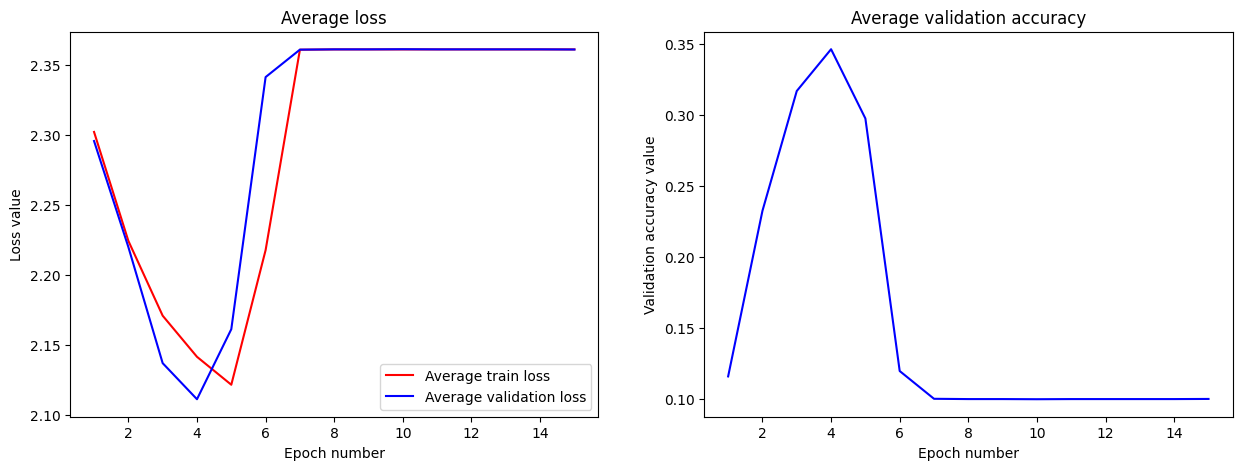

In [46]:
ModelCycles.plot_loss_acc(15, CAN_lr_up_model_cycle.train_loss_arr, CAN_lr_up_model_cycle.val_loss_arr, CAN_lr_up_model_cycle.val_accuracy_arr)

### As we see, with with higher learning rate model reaches higher accuracy much faster, although then the results return back to random classifier

In [47]:
test_loss_score, test_accuracy_score = CAN_lr_up_model_cycle.model_test()
print(f"Test loss: {test_loss_score}")
print(f"Test accuracy: {test_accuracy_score}")

Test loss: 2.3611016273498535
Test accuracy: 0.10003993660211563


In [49]:
# Model with lower momentum
custom_alexnet_momtum_down = CustomAlexNet().to(device)
optimizer = optim.SGD(custom_alexnet_momtum_down.parameters(), lr=0.001, momentum=0.75)
CAN_momtum_down_model_cycle = ModelCycles(custom_alexnet_momtum_down, optimizer, criterion, accuracy, 
                                    train_loader, val_loader, test_loader, device)
CAN_momtum_down_model_cycle.train_validate_cycle(15, 400, 2)

Current epoch: 2
-------
Looked at 12768 samples
Current train loss for batch: 2.3021559715270996
Looked at 25568 samples
Current train loss for batch: 2.3026132583618164
Looked at 38368 samples
Current train loss for batch: 2.302703380584717

Average train loss: 2.30257
Average validation loss: 2.30256, Average validation acc: 0.10%

Current epoch: 4
-------
Looked at 12768 samples
Current train loss for batch: 2.3023600578308105
Looked at 25568 samples
Current train loss for batch: 2.3022942543029785
Looked at 38368 samples
Current train loss for batch: 2.302650213241577

Average train loss: 2.30254
Average validation loss: 2.30253, Average validation acc: 0.10%

Current epoch: 6
-------
Looked at 12768 samples
Current train loss for batch: 2.3019399642944336
Looked at 25568 samples
Current train loss for batch: 2.3022820949554443
Looked at 38368 samples
Current train loss for batch: 2.302415132522583

Average train loss: 2.30251
Average validation loss: 2.30248, Average validation a

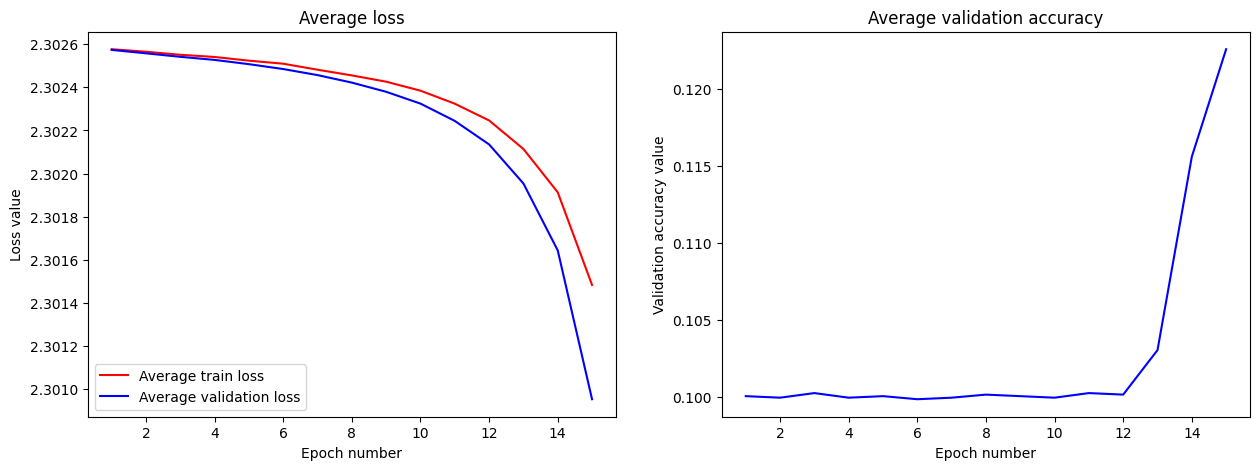

In [50]:
ModelCycles.plot_loss_acc(15, CAN_momtum_down_model_cycle.train_loss_arr, CAN_momtum_down_model_cycle.val_loss_arr, CAN_momtum_down_model_cycle.val_accuracy_arr)

### As we see, with smaller momentum accuracy starts to rise later (i.e. slower convergence)

In [51]:
test_loss_score, test_accuracy_score = CAN_momtum_down_model_cycle.model_test()
print(f"Test loss: {test_loss_score}")
print(f"Test accuracy: {test_accuracy_score}")

Test loss: 2.3009238243103027
Test accuracy: 0.125


In [53]:
# AlexNet with no dropout
custom_alexnet_no_drop = CustomAlexNet(dropout=0).to(device)
optimizer = optim.SGD(custom_alexnet_no_drop.parameters(), lr=0.001, momentum=0.9)
CAN_no_drop_model_cycle = ModelCycles(custom_alexnet_no_drop, optimizer, criterion, accuracy, 
                                    train_loader, val_loader, test_loader, device)
CAN_no_drop_model_cycle.train_validate_cycle(20, 400, 2)

Current epoch: 2
-------
Looked at 12768 samples
Current train loss for batch: 2.302621841430664
Looked at 25568 samples
Current train loss for batch: 2.3022942543029785
Looked at 38368 samples
Current train loss for batch: 2.3023905754089355

Average train loss: 2.30249
Average validation loss: 2.30244, Average validation acc: 0.10%

Current epoch: 4
-------
Looked at 12768 samples
Current train loss for batch: 2.3020429611206055
Looked at 25568 samples
Current train loss for batch: 2.301964282989502
Looked at 38368 samples
Current train loss for batch: 2.300964593887329

Average train loss: 2.30203
Average validation loss: 2.30161, Average validation acc: 0.14%

Current epoch: 6
-------
Looked at 12768 samples
Current train loss for batch: 2.2433278560638428
Looked at 25568 samples
Current train loss for batch: 2.196424722671509
Looked at 38368 samples
Current train loss for batch: 2.1744608879089355

Average train loss: 2.21143
Average validation loss: 2.16905, Average validation ac

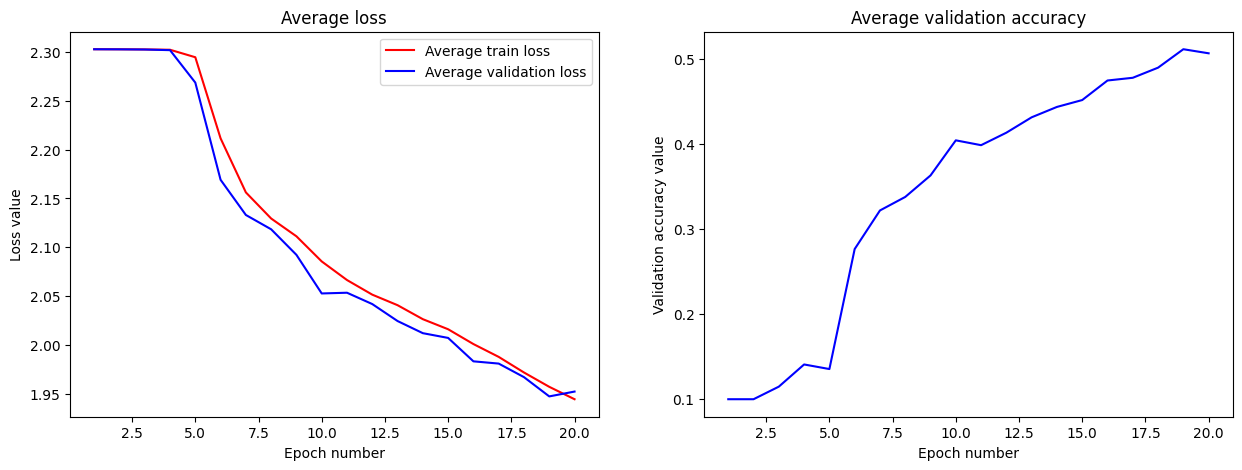

In [54]:
ModelCycles.plot_loss_acc(20, CAN_no_drop_model_cycle.train_loss_arr, CAN_no_drop_model_cycle.val_loss_arr, CAN_no_drop_model_cycle.val_accuracy_arr)

In [55]:
test_loss_score, test_accuracy_score = CAN_no_drop_model_cycle.model_test()
print(f"Test loss: {test_loss_score}")
print(f"Test accuracy: {test_accuracy_score}")

Test loss: 1.9483665227890015
Test accuracy: 0.509984016418457


### As we see, the results with no dropout after 20 epochs are pretty much the same as with dropout=0.5 for loss, although the accuracy is rising much faster. In theory, dropout is used to prevent overfitting, but to confitm it on this example, further training is required.

In [56]:
# Save weights to file 'AlexNet_nonPL_CIFAR10_weights.pth'
torch.save(custom_alexnet_no_drop.state_dict(), 'CustomAlexNetnd_20epoch.pth')
# To load weigths:
# custom_alexnet_pretr.load_state_dict(torch.load('CustomAlexNet_140epoch.pth''))
# custom_alexnet_pretr.eval()
np.save('train_loss_arr_nd20.npy', CAN_no_drop_model_cycle.train_loss_arr)
np.save('val_loss_arr_nd20.npy', CAN_no_drop_model_cycle.val_loss_arr)
np.save('val_accuracy_arr_nd20.npy', CAN_no_drop_model_cycle.val_accuracy_arr)

## Conclusions 
### After training first model (dropout=0.5, learning_rate=0.001, momentum=0.9) for 140 epoch we obtained pretty decent result of 76.12% accuracy on the test set. It's better not to train the model further, because it will start to overfit and generilise worse. Based on the results, we can conclude that AlexNet is suited quite well for CIFAR10 dataset. As we see on experiments with hyperparameters, they have big impact on the model performance, so they should be tuned with the use of cross-validation (StratifyKFold, GroupKFold, etc.) and grid-search, with the use of train and validations datasets. Test set is used to access the performance of our resulting model.